In [1]:
import os
import time
import glob
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.cluster import Birch
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
from datetime import datetime

## Step 0: Data pre-processing

In [2]:
path = "training_data/2020_04_11/trace/"
df = pd.read_csv(path+'trace_data_sample.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,dsName
0,OSB,1586534400045,1116.0,True,0734417164d1c02d4468,3166517164d1c02d4470,None,os_022,osb_001,NaN
1,OSB,1586534400045,1116.0,True,0734417164d1c02d4468,3166517164d1c02d4470,None,os_022,osb_001,NaN
2,OSB,1586534400045,1007.0,True,b362c17164d1c02d4469,efd1717164d1c02d4471,None,os_022,osb_001,NaN
3,OSB,1586534400045,1007.0,True,b362c17164d1c02d4469,efd1717164d1c02d4471,None,os_022,osb_001,NaN
4,CSF,1586534400053,1086.0,True,0734417164d1c02d4468,efad117164d1c0354473,3166517164d1c02d4470,os_022,csf_001,NaN
...,...,...,...,...,...,...,...,...,...,...
89701,CSF,1586534760709,23.0,True,5b46417164d73f935996,7b7be17164d741055043,008ec17164d73fbd4690,docker_002,csf_004,NaN
89702,CSF,1586534760733,21.0,True,5b46417164d73f935996,e9c0217164d7411d5045,008ec17164d73fbd4690,docker_002,csf_005,NaN
89703,CSF,1586534760734,1454.0,True,fff4d17164d740eb6004,f22a117164d7411e6007,895aa17164d740eb6005,os_022,csf_001,NaN
89704,CSF,1586534760788,36.0,True,fff4d17164d740eb6004,26e6e17164d741535076,c8da017164d741205047,docker_002,csf_002,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89706 entries, 0 to 89705
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   callType     89706 non-null  object 
 1   startTime    89706 non-null  int64  
 2   elapsedTime  89706 non-null  float64
 3   success      89706 non-null  bool   
 4   traceId      89706 non-null  object 
 5   id           89706 non-null  object 
 6   pid          89706 non-null  object 
 7   cmdb_id      89706 non-null  object 
 8   serviceName  53074 non-null  object 
 9   dsName       64792 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 6.2+ MB


In [7]:
def data_processing(data):
        # data['serviceName'] = data['serviceName'].mask(
        #     pd.isnull, data['dsName'])

        # data['callType'] = pd.Categorical(data['callType'], ["OSB", "CSF", "LOCAL", "FlyRemote", "RemoteProcess", "JDBC"])
        # data = data.sort_values(["traceId","startTime"], ignore_index=True)
        # data = data.sort_values(["startTime"], ignore_index=True)
        # data = data[data.startTime < data.startTime[0]+100000]
        print(len(data))
        print('got subset')

        start_time = datetime.now()

        # Get the child's id and elapse time
        elapse_time = {}
        children = {}
        parent_service = {}
        for index, row in data.iterrows():
            if row['pid'] != 'None':
                if row['pid'] in children.keys():
                    children[row['pid']].append(row['id'])
                else:
                    children[row['pid']] = [row['id']]
            elapse_time[row['id']] = float(row['elapsedTime'])
            # If dont need parent node's info in path column just comment this
            parent_service[row['id']] = row['cmdb_id'] +':' + row['serviceName']

        # Compute for actual elapse_time and edge
        data['actual_time'] = 0.0
        data['path'] = ''
        for index, row in data.iterrows():
            total_child = 0.0

            # If dont need parent node's info in path column just comment this part
            if row['pid'] not in parent_service.keys():
                data.at[index, 'path'] = 'Start-' + \
                    row['cmdb_id'] + ':' + row['serviceName']
            else:
                data.at[index, 'path'] = parent_service[row['pid']] + \
                    '-' + row['cmdb_id'] + ':' + row['serviceName']

            if row['id'] not in children.keys():
                data.at[index, 'actual_time'] = row['elapsedTime']
                continue
            for child in children[row['id']]:
                total_child += elapse_time[child]
            data.at[index, 'actual_time'] = row['elapsedTime'] - total_child

        data['host_service'] = data.path.str.split('-').str[1]
        data['parent_host_service'] = data.path.str.split('-').str[0]
        data['parent'] = data.parent_host_service.str.split(':').str[1]

        strs = []
        structure_dict = {}
        data['trace_class'] = -1
        for name, group in data.groupby(['traceId']):
            structure = list(group.path.unique())
            structure.sort()
            if not (structure in strs):
                strs.append(structure)
                structure_dict[strs.index(structure)] = structure
            data.loc[data.traceId == name, ['trace_class']] = strs.index(structure)

        print(len(strs))

        total = datetime.now() - start_time
        print(total.total_seconds())

        return (data, structure_dict)

In [8]:
data, structure_dict = data_processing(df)

89706
got subset


TypeError: can only concatenate str (not "float") to str

In [6]:
data.drop('Unnamed: 0', axis=1, inplace = True)

## Step 1: MPG

In [9]:
  def mpg(trace_data, structure_dict):
        dgs = {}
        for clss, structure in structure_dict.items():
            DG = nx.DiGraph()
            for path in structure:
                s, d = path.split('-')
                if s != 'Start':
                    sourcehost, source = s.split(':')
                    destinationhost, destination = d.split(':')
                    DG.add_edge(source,destination)
                    DG.nodes[source]['type'] = 'service'
                    DG.nodes[destination]['type'] = 'service'

                    DG.add_edge(source, sourcehost)                
                    DG.nodes[sourcehost]['type'] = 'host'

                    DG.add_edge(destination, destinationhost)          
                    DG.nodes[destinationhost]['type'] = 'host'
                else:
                    destinationhost, destination = d.split(':')
                    DG.add_edge(destination, destinationhost)    
                    DG.nodes[destination]['type'] = 'service'   
                    DG.nodes[destinationhost]['type'] = 'host'
            dgs[clss] = DG      

        return dgs

dgs = mpg(data, structure_dict)

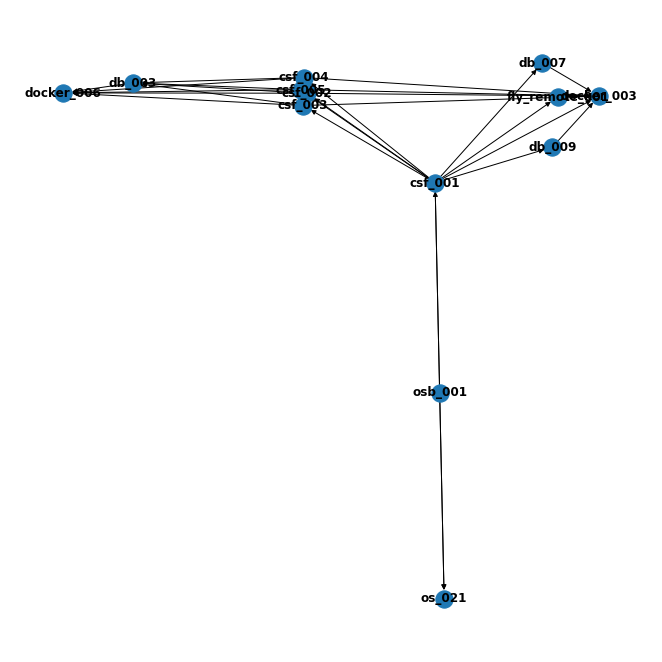

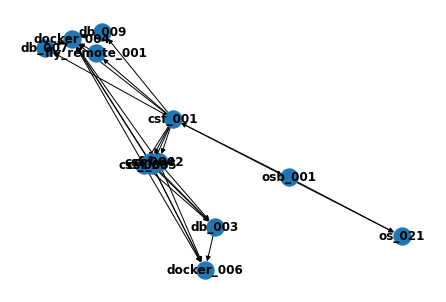

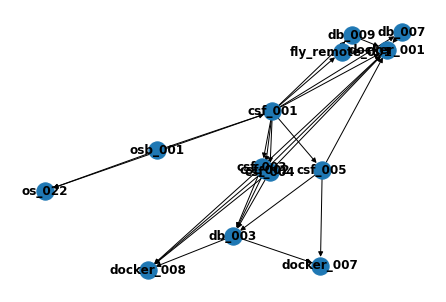

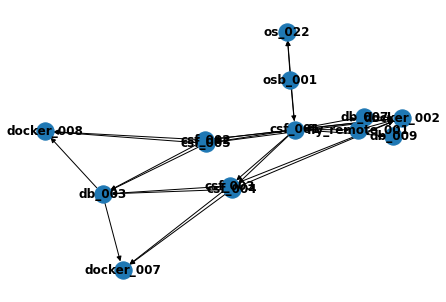

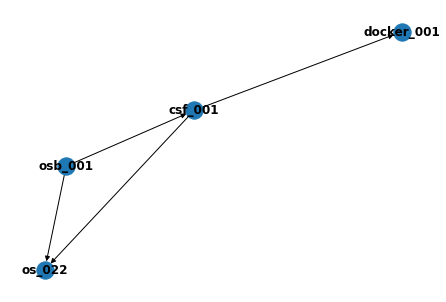

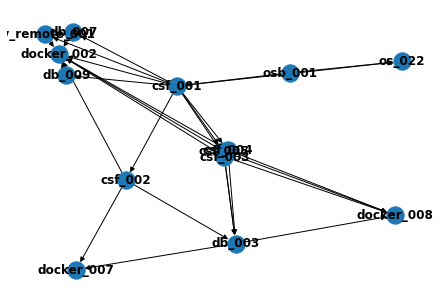

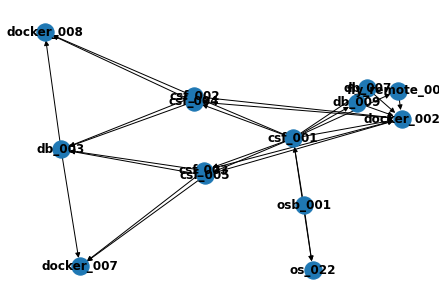

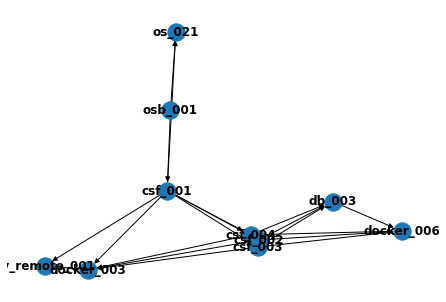

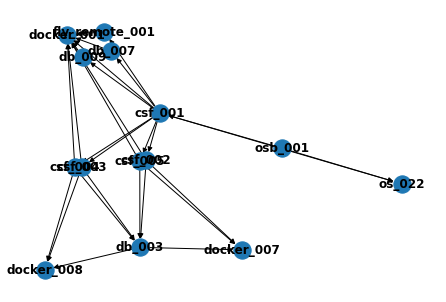

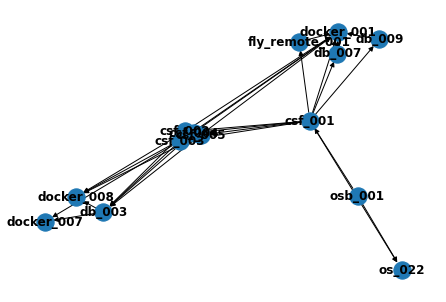

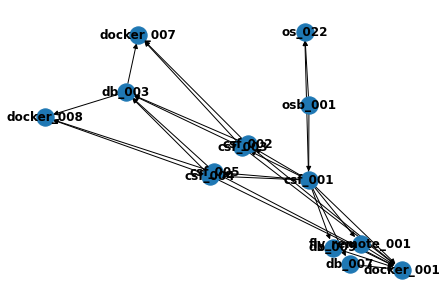

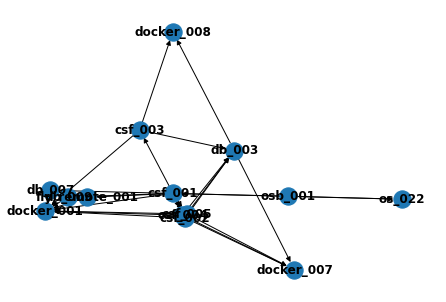

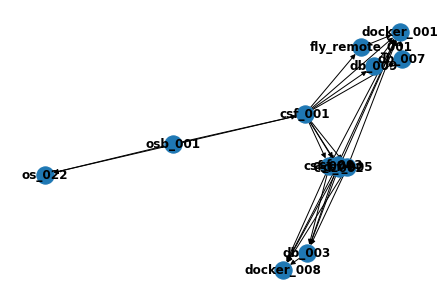

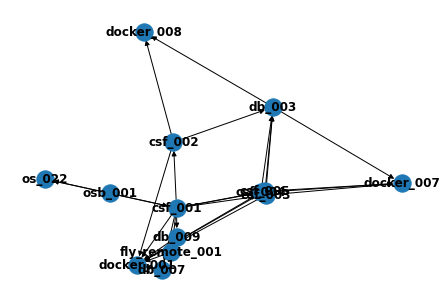

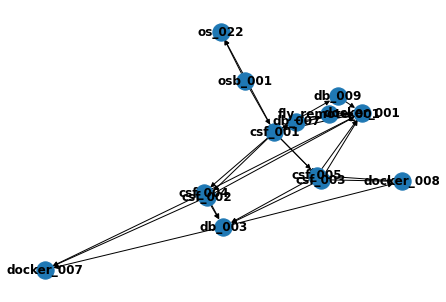

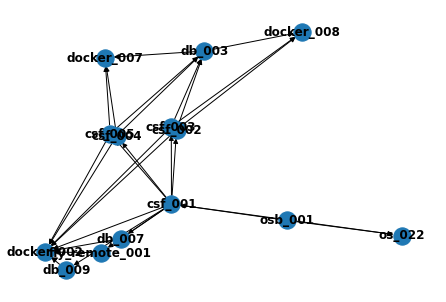

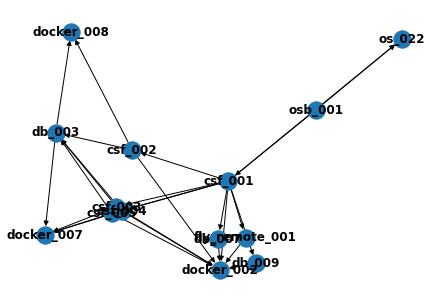

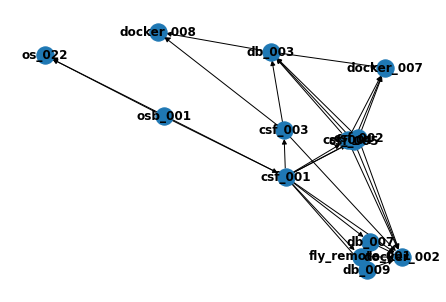

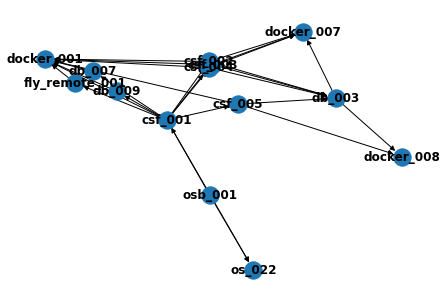

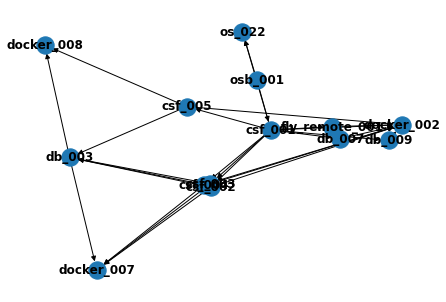

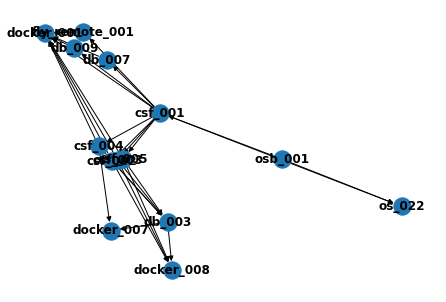

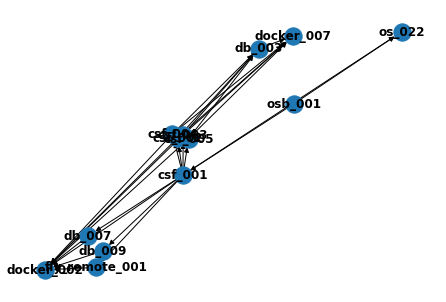

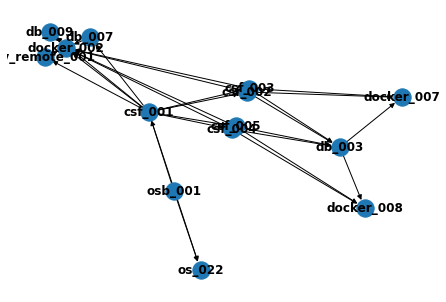

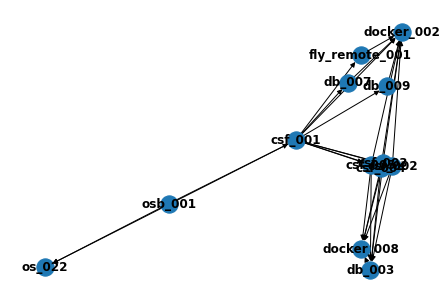

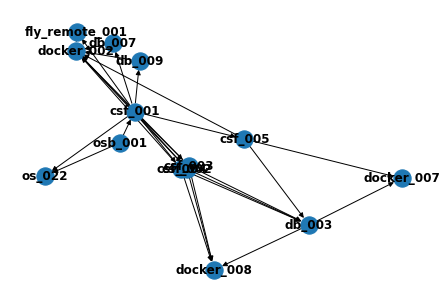

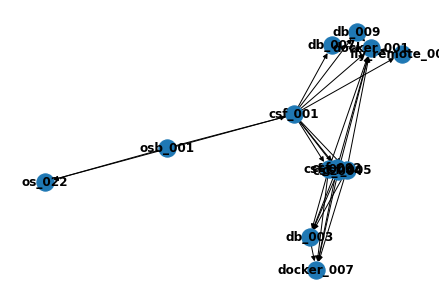

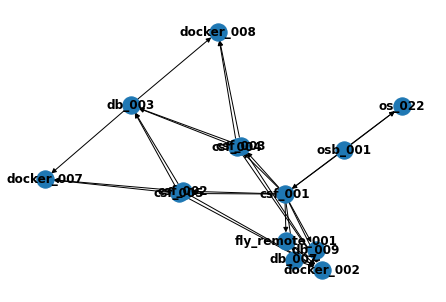

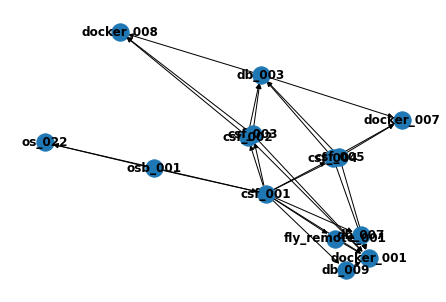

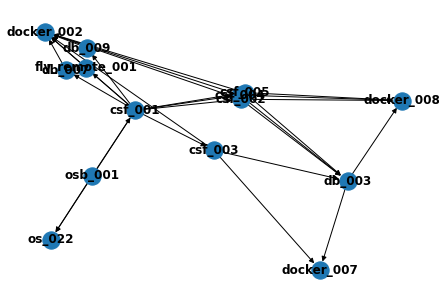

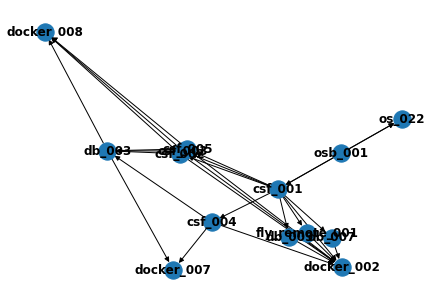

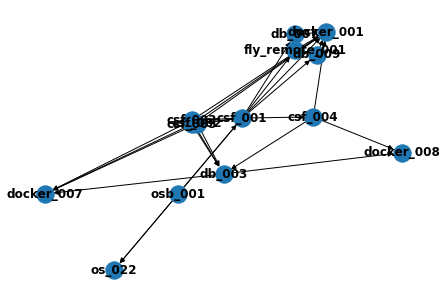

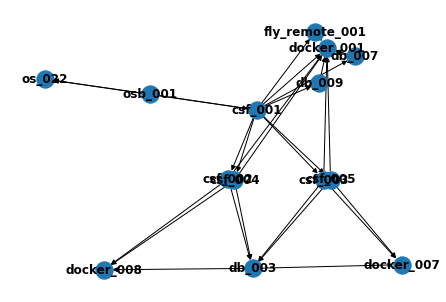

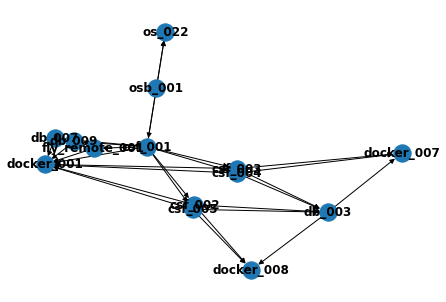

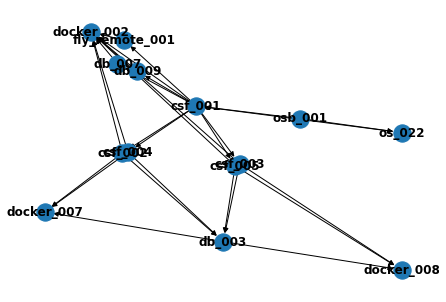

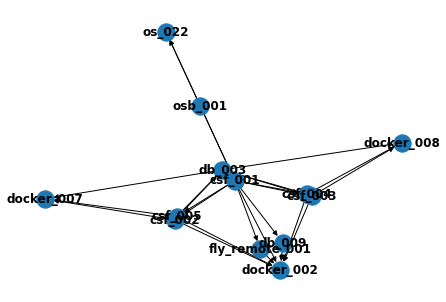

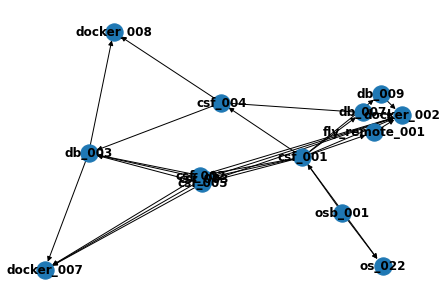

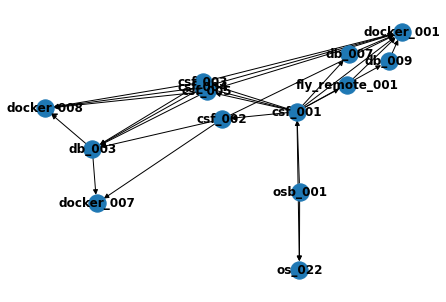

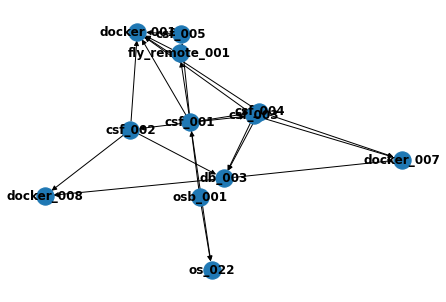

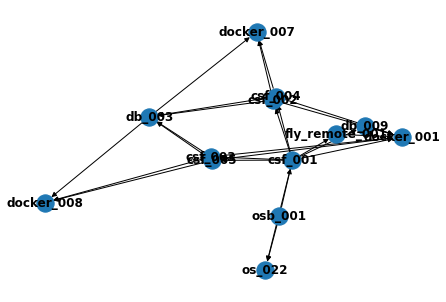

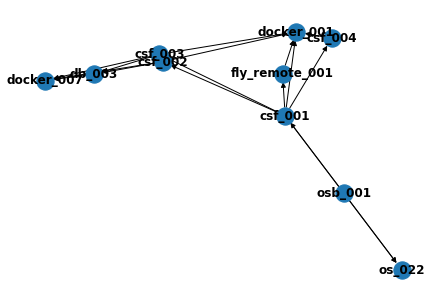

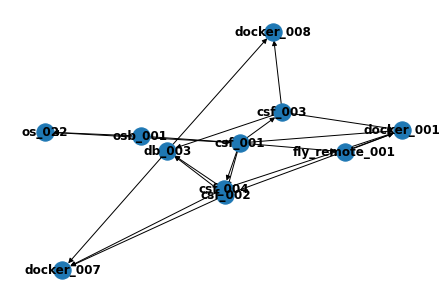

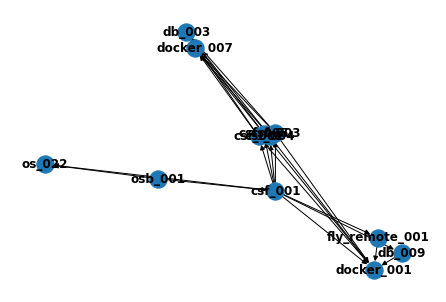

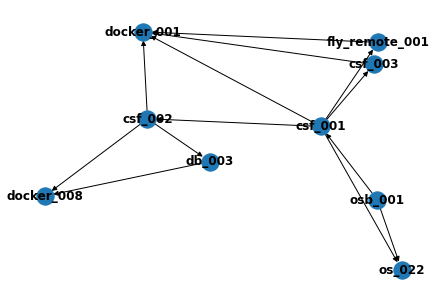

In [18]:
plt.figure(figsize=(9,9))
for i in range(len(dgs)):
    nx.draw(dgs[i], with_labels=True, font_weight='bold')
    plt.show()

In [19]:
path = "training_data/2020_05_04/host/"
host_data = pd.read_csv(path + 'host_data_full.csv', index_col=False)
host_data.drop('Unnamed: 0', axis=1, inplace = True)
host_data = host_data[host_data.timestamp < host_data.timestamp[0]+100000]

In [21]:
def anomaly_detection(data):
    anomalies = {}
    for clss in list(data.trace_class.unique()):
        services = data[data.trace_class == clss].path.unique()
        ans = []
        for col in list(services):
            time_vals = data[(data["path"] == col) & (data['trace_class'] == clss)]['actual_time']
            anomaly = birch_algorithm(
                time_vals, smoothing_window=12, threshold=0.03)
            if anomaly:
                nodes = col.split('-')
                ans.append(nodes)

        anomalies[clss] = ans
    return anomalies

def birch_algorithm(latency, smoothing_window=12, threshold=0.03):
        # put your version here herny
        latency = latency.rolling(
            window=smoothing_window, min_periods=1).mean()
        x = np.array(latency)
        x = np.where(np.isnan(x), 0, x)
        normalized_x = preprocessing.normalize([x])

        X = normalized_x.reshape(-1, 1)

        brc = Birch(branching_factor=50, n_clusters=None,
                    threshold=threshold, compute_labels=True)
        brc.fit(X)
        brc.predict(X)
        labels = brc.labels_
        n_clusters = np.unique(labels).size

        if n_clusters > 1:
            return True  # True if anomaly
        return False

In [22]:
def extract_subgraphs(graphs, anomalies, trace_data, host_data, alpha=0.55):
    scores = {}
    for clss, graph in graphs.items():
        subset_data = trace_data.loc[trace_data.trace_class == clss]
        score = subgraph_extraction(graph, anomalies[clss], subset_data, host_data, alpha)
        scores[clss] = score
        print('Trace Class %d' % clss)
        print(score)
    return scores

def subgraph_extraction(DG, anomalies, trace_data, host_data, alpha=0.55):
        baseline_df = {}
        nodes = []
        nodes_with_host = []
        anomaly_edges = []
        for sauce, dest in anomalies:
            h, d = dest.split(':')
            nodes.append(d)
            nodes_with_host.append((d,h))
            baseline_df[d] = trace_data.loc[trace_data.path == sauce + '-' + dest]
            if sauce != 'Start':
                s = sauce.split(':')[1]
                anomaly_edges.append((s,d))

        nodes = list(set(nodes))
            
        subgraph = nx.DiGraph()
        for node in nodes:
            for u, v, d in DG.in_edges(node, data=True):
                if (u, v) in anomaly_edges:
                    d = alpha
                else:
                    normal = trace_data.loc[(trace_data.serviceName == v) & (trace_data.parent==u)]['actual_time']
                    anomalous = baseline_df[v]['actual_time']
                    if len(normal)==1 or len(anomalous)==1:
                        d=0
                    else:
                        d = anomalous.corr(normal)
                        if math.isnan(d):
                            d = 0

                d = round(d, 3)
                subgraph.add_edge(u,v, weight=d)
                subgraph.nodes[u]['type'] = DG.nodes[u]['type']
                subgraph.nodes[v]['type'] = DG.nodes[v]['type']

            for u, v, d in DG.out_edges(node, data=True):
                if (u,v) in anomaly_edges:
                    d = alpha
                else:
                    if DG.nodes[v]['type'] == 'host':
                        d, col = node_weight(u, v, subgraph, baseline_df, host_data)
                    else:
                        normal = trace_data.loc[(trace_data.serviceName == v) & (trace_data.parent==u)]['actual_time']
                        anomalous = baseline_df[u]['actual_time']
                        if len(normal)==1 or len(anomalous)==1:
                            d=0
                        else:
                            d = anomalous.corr(normal)
                            if math.isnan(d):
                                d = 0
                d = round(d, 3)
                subgraph.add_edge(u,v, weight=d)
                subgraph.nodes[u]['type'] = DG.nodes[u]['type']
                subgraph.nodes[v]['type'] = DG.nodes[v]['type']


        personalization = {}
        for node in DG.nodes():
            if node in nodes:
                personalization[node] = 0

        for node, host in nodes_with_host:
            max_corr, metric = node_personalization(node, host, subgraph, baseline_df, host_data)
            personalization[node] = max_corr / subgraph.degree(node)
        
        anomaly_graph = subgraph.reverse(copy=True)

        edges = list(anomaly_graph.edges(data=True))

        for u, v, d in edges:
            if anomaly_graph.nodes[node]['type'] == 'host':
                anomaly_graph.remove_edge(u,v)
                anomaly_graph.add_edge(v,u,weight=d['weight'])

        anomaly_score = nx.pagerank(anomaly_graph, alpha=0.85, personalization=personalization, max_iter=10000)

        anomaly_score = sorted(anomaly_score.items(), key=lambda x: x[1], reverse=True)
        final_score = []
        for a, b in anomaly_score:
            if b > 0.5:
                final_score.append((a,b))
        return final_score


def node_weight(service, host, subgraph, baseline_df, host_data):
        in_edges_weight_avg = 0.0
        num = 0
        for _, _, data in subgraph.in_edges(service, data=True):
            num = num + 1
            in_edges_weight_avg = in_edges_weight_avg + data['weight']
        if num > 0:
            in_edges_weight_avg  = in_edges_weight_avg / num

        
        host_subset = host_data.loc[host_data.cmdb_id == host]        
        KPIs = list(host_subset.name.dropna().unique())
        max_corr = 0.01
        metric = -1
        for kpi in KPIs:
            service_times = baseline_df[service]['actual_time']
            kpi_times = host_subset.loc[host_subset['name'] == kpi]['value']
            temp = 0
            if len(service_times)>1 and len(kpi_times)>1:
                temp = abs(service_times.corr(kpi_times))
            if math.isnan(temp):
                temp = 0
            if temp > max_corr:
                max_corr = temp
                metric = kpi 

        data = in_edges_weight_avg * max_corr
        return data, metric



def node_personalization(service, service_host, subgraph, baseline_df, host_data):
    host_subset = host_data.loc[host_data.cmdb_id == service_host]        
    KPIs = list(host_subset.name.dropna().unique())
    max_corr = 0.01
    metric = -1
    for kpi in KPIs:
        service_times = baseline_df[service]['actual_time']
        kpi_times = host_subset.loc[host_subset['name'] == kpi]['value']
        temp = 0
        if len(service_times)>1 and len(kpi_times)>1:
            temp = abs(service_times.corr(kpi_times))
        if math.isnan(temp):
            temp = 0
        if temp > max_corr:
            max_corr = temp
            metric = kpi      

    edges_weight_avg = 0.0
    num = 0
    for _, _, data in subgraph.in_edges(service, data=True):
        num += 1
        edges_weight_avg = edges_weight_avg + data['weight']

    for _, v, data in subgraph.out_edges(service, data=True):
        if subgraph.nodes[v]['type'] == 'service':
            num += 1
            edges_weight_avg = edges_weight_avg + data['weight']

    edges_weight_avg  = edges_weight_avg / num

    personalization = edges_weight_avg * max_corr

    return (personalization, metric)

In [23]:
anomalies = anomaly_detection(data)

In [28]:
anomaly_score = extract_subgraphs(dgs, anomalies, data, host_data, 0.55)

Trace Class 0
[]
Trace Class 1
[]
Trace Class 2
[]
Trace Class 3
[]
Trace Class 4
[]
Trace Class 5
[]
Trace Class 6
[]
Trace Class 7
[]
Trace Class 8
[]
Trace Class 9
[]
Trace Class 10
[]
Trace Class 11
[]
Trace Class 12
[]
Trace Class 13
[]
Trace Class 14
[]
Trace Class 15
[]
Trace Class 16
[]
Trace Class 17
[]
Trace Class 18
[]
Trace Class 19
[]
Trace Class 20
[]
Trace Class 21
[]
Trace Class 22
[]
Trace Class 23
[]
Trace Class 24
[]
Trace Class 25
[]
Trace Class 26
[]
Trace Class 27
[]
Trace Class 28
[]
Trace Class 29
[]
Trace Class 30
[]
Trace Class 31
[]
Trace Class 32
[]
Trace Class 33
[]
Trace Class 34
[('db_009', 0.542302447233569)]
Trace Class 35
[]
Trace Class 36
[]
Trace Class 37
[('db_003', 0.5405419145268264)]
Trace Class 38
[('db_009', 0.542302447233569)]
Trace Class 39
[('db_003', 0.7017538741354769)]
Trace Class 40
[('db_003', 0.5405419145268264)]
Trace Class 41
[('db_009', 0.5252527592170866)]
Trace Class 42
[]
